In [1]:
import sys
import yaml
import xarray as xr
import numpy as np
import pandas as pd
import itertools
%matplotlib inline
# import wrf

# plot styles/formatting
from matplotlib import cm
import seaborn as sns
import cmocean.cm as cmo
import cmocean

# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar # different way to handle colorbar
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature


# import personal modules
# Path to modules
sys.path.append('../modules')
# Import my modules
from plotter import draw_basemap

In [2]:
path_to_data = '/expanse/nfs/cw3e/cwp140/'
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [3]:
# import configuration file for case study choice
yaml_doc = '../data/domains.yml'
config = yaml.load(open(yaml_doc), Loader=yaml.SafeLoader)        

In [4]:
## iterate through options
# ssn_lst = ['DJF', 'MAM', 'JJA', 'SON', 'NDJFMA', 'MJJASO']
ssn = 'SON'
## iterate through options
region_lst = ['baja', 'san_juan', 'gulf_of_mexico']
varname_lst = ['700z', 'ivt']
lag_lst = [0, 1]

ext = [-140., -90., 20, 50]
ds_lst3 = []
ds_lst4 = []
for h, region in enumerate(region_lst):  
    tmp_lst = []
    tmp_lst2 = []
    for i, varname in enumerate(varname_lst):  
        ds_lst = []
        ds_lst2 = []
        for j, lag in enumerate(lag_lst):
            ## load anomaly composite data
            path = '/home/dnash/DATA/preprocessed/ERA5_composites/'
            fname1 = path + '{0}/{2}/filtered_anomaly_composite_{0}_{1}_lag{3}.nc'.format(varname, ssn, region, lag)
            fname2 = path + '{0}/{2}/filtered_anomaly_composite_tvals_{0}_{1}_lag{3}.nc'.format(varname, ssn, region, lag)
        
            ds = xr.open_dataset(fname1)
            ds = ds.sel(latitude=slice(ext[3], ext[2]), longitude=slice(ext[0], ext[1]))
            ds_lst.append(ds)
    
            ds2 = xr.open_dataset(fname2)
            ds2 = ds2.sel(latitude=slice(ext[3], ext[2]), longitude=slice(ext[0], ext[1]))
            ds_lst2.append(ds2)
    
        ## concat ds_lst along ssn
        tmp = xr.concat(ds_lst, pd.Index(lag_lst, name="lag"))
        tmp_lst.append(tmp)
    
        tmp2 = xr.concat(ds_lst2, pd.Index(lag_lst, name="lag"))
        tmp_lst2.append(tmp2)

    ## merge two datasets
    ds3 = xr.merge(tmp_lst)
    ds_lst3.append(ds3)

    ## merge tvalue anomaly datasets
    ds4 = xr.merge(tmp_lst2)
    ds_lst4.append(ds4)

ds_hc = xr.concat(ds_lst3, pd.Index(region_lst, name="region"))
ds_tval = xr.concat(ds_lst4, pd.Index(region_lst, name="region"))

In [5]:
ds_hc

<xarray.Dataset>
Dimensions:    (longitude: 201, latitude: 121, region: 3, lag: 2)
Coordinates:
  * longitude  (longitude) float32 -140.0 -139.8 -139.5 ... -90.5 -90.25 -90.0
  * latitude   (latitude) float32 50.0 49.75 49.5 49.25 ... 20.5 20.25 20.0
  * lag        (lag) int64 0 1
  * region     (region) object 'baja' 'san_juan' 'gulf_of_mexico'
Data variables:
    z          (region, lag, latitude, longitude) float64 241.4 231.8 ... -55.03
    ndays      (region, lag) int64 314 315 276 276 60 60
    ivtv       (region, lag, latitude, longitude) float64 -70.41 ... 7.582
    ivtu       (region, lag, latitude, longitude) float64 17.82 16.88 ... -49.53
    ivt        (region, lag, latitude, longitude) float64 -1.307 ... 7.785

In [6]:
ds_tval

<xarray.Dataset>
Dimensions:    (longitude: 201, latitude: 121, region: 3, lag: 2)
Coordinates:
  * longitude  (longitude) float32 -140.0 -139.8 -139.5 ... -90.5 -90.25 -90.0
  * latitude   (latitude) float32 50.0 49.75 49.5 49.25 ... 20.5 20.25 20.0
  * lag        (lag) int64 0 1
  * region     (region) object 'baja' 'san_juan' 'gulf_of_mexico'
Data variables:
    z          (region, lag, latitude, longitude) bool True True ... True True
    ivtv       (region, lag, latitude, longitude) bool True True ... False False
    ivtu       (region, lag, latitude, longitude) bool True True ... True True
    ivt        (region, lag, latitude, longitude) bool False False ... False

In [7]:
# Set up projection
# mapcrs = ccrs.Mercator()
mapcrs = ccrs.PlateCarree()
datacrs = ccrs.PlateCarree()

# Set lat/lons
lats = ds.latitude.values
lons = ds.longitude.values

# Set tick/grid locations
tx = 10
ty = 5
dx = np.arange(ext[0],ext[1]+tx,tx)
dy = np.arange(ext[2],ext[3]+ty,ty)

# list of letters to append to titles
letter_lst = list(map(chr, range(97, 123)))

-35.56943614423039 78.33150694254303
-5.604460573001187 2.4624800702257197
-27.08225633666869 103.81923115069708
-5.923841571067146 2.6246832336513792
-49.553176051487405 132.65006250062984
-5.755483170156239 5.5372795619411335
-35.42491805103645 90.788726169083
-6.172078473295823 2.763063533707432
-23.550182786593535 108.03987322303996
-4.4391673801327585 2.5003795766761687
-48.133282159955314 169.09917378029886
-5.615320726537938 6.513607341590091


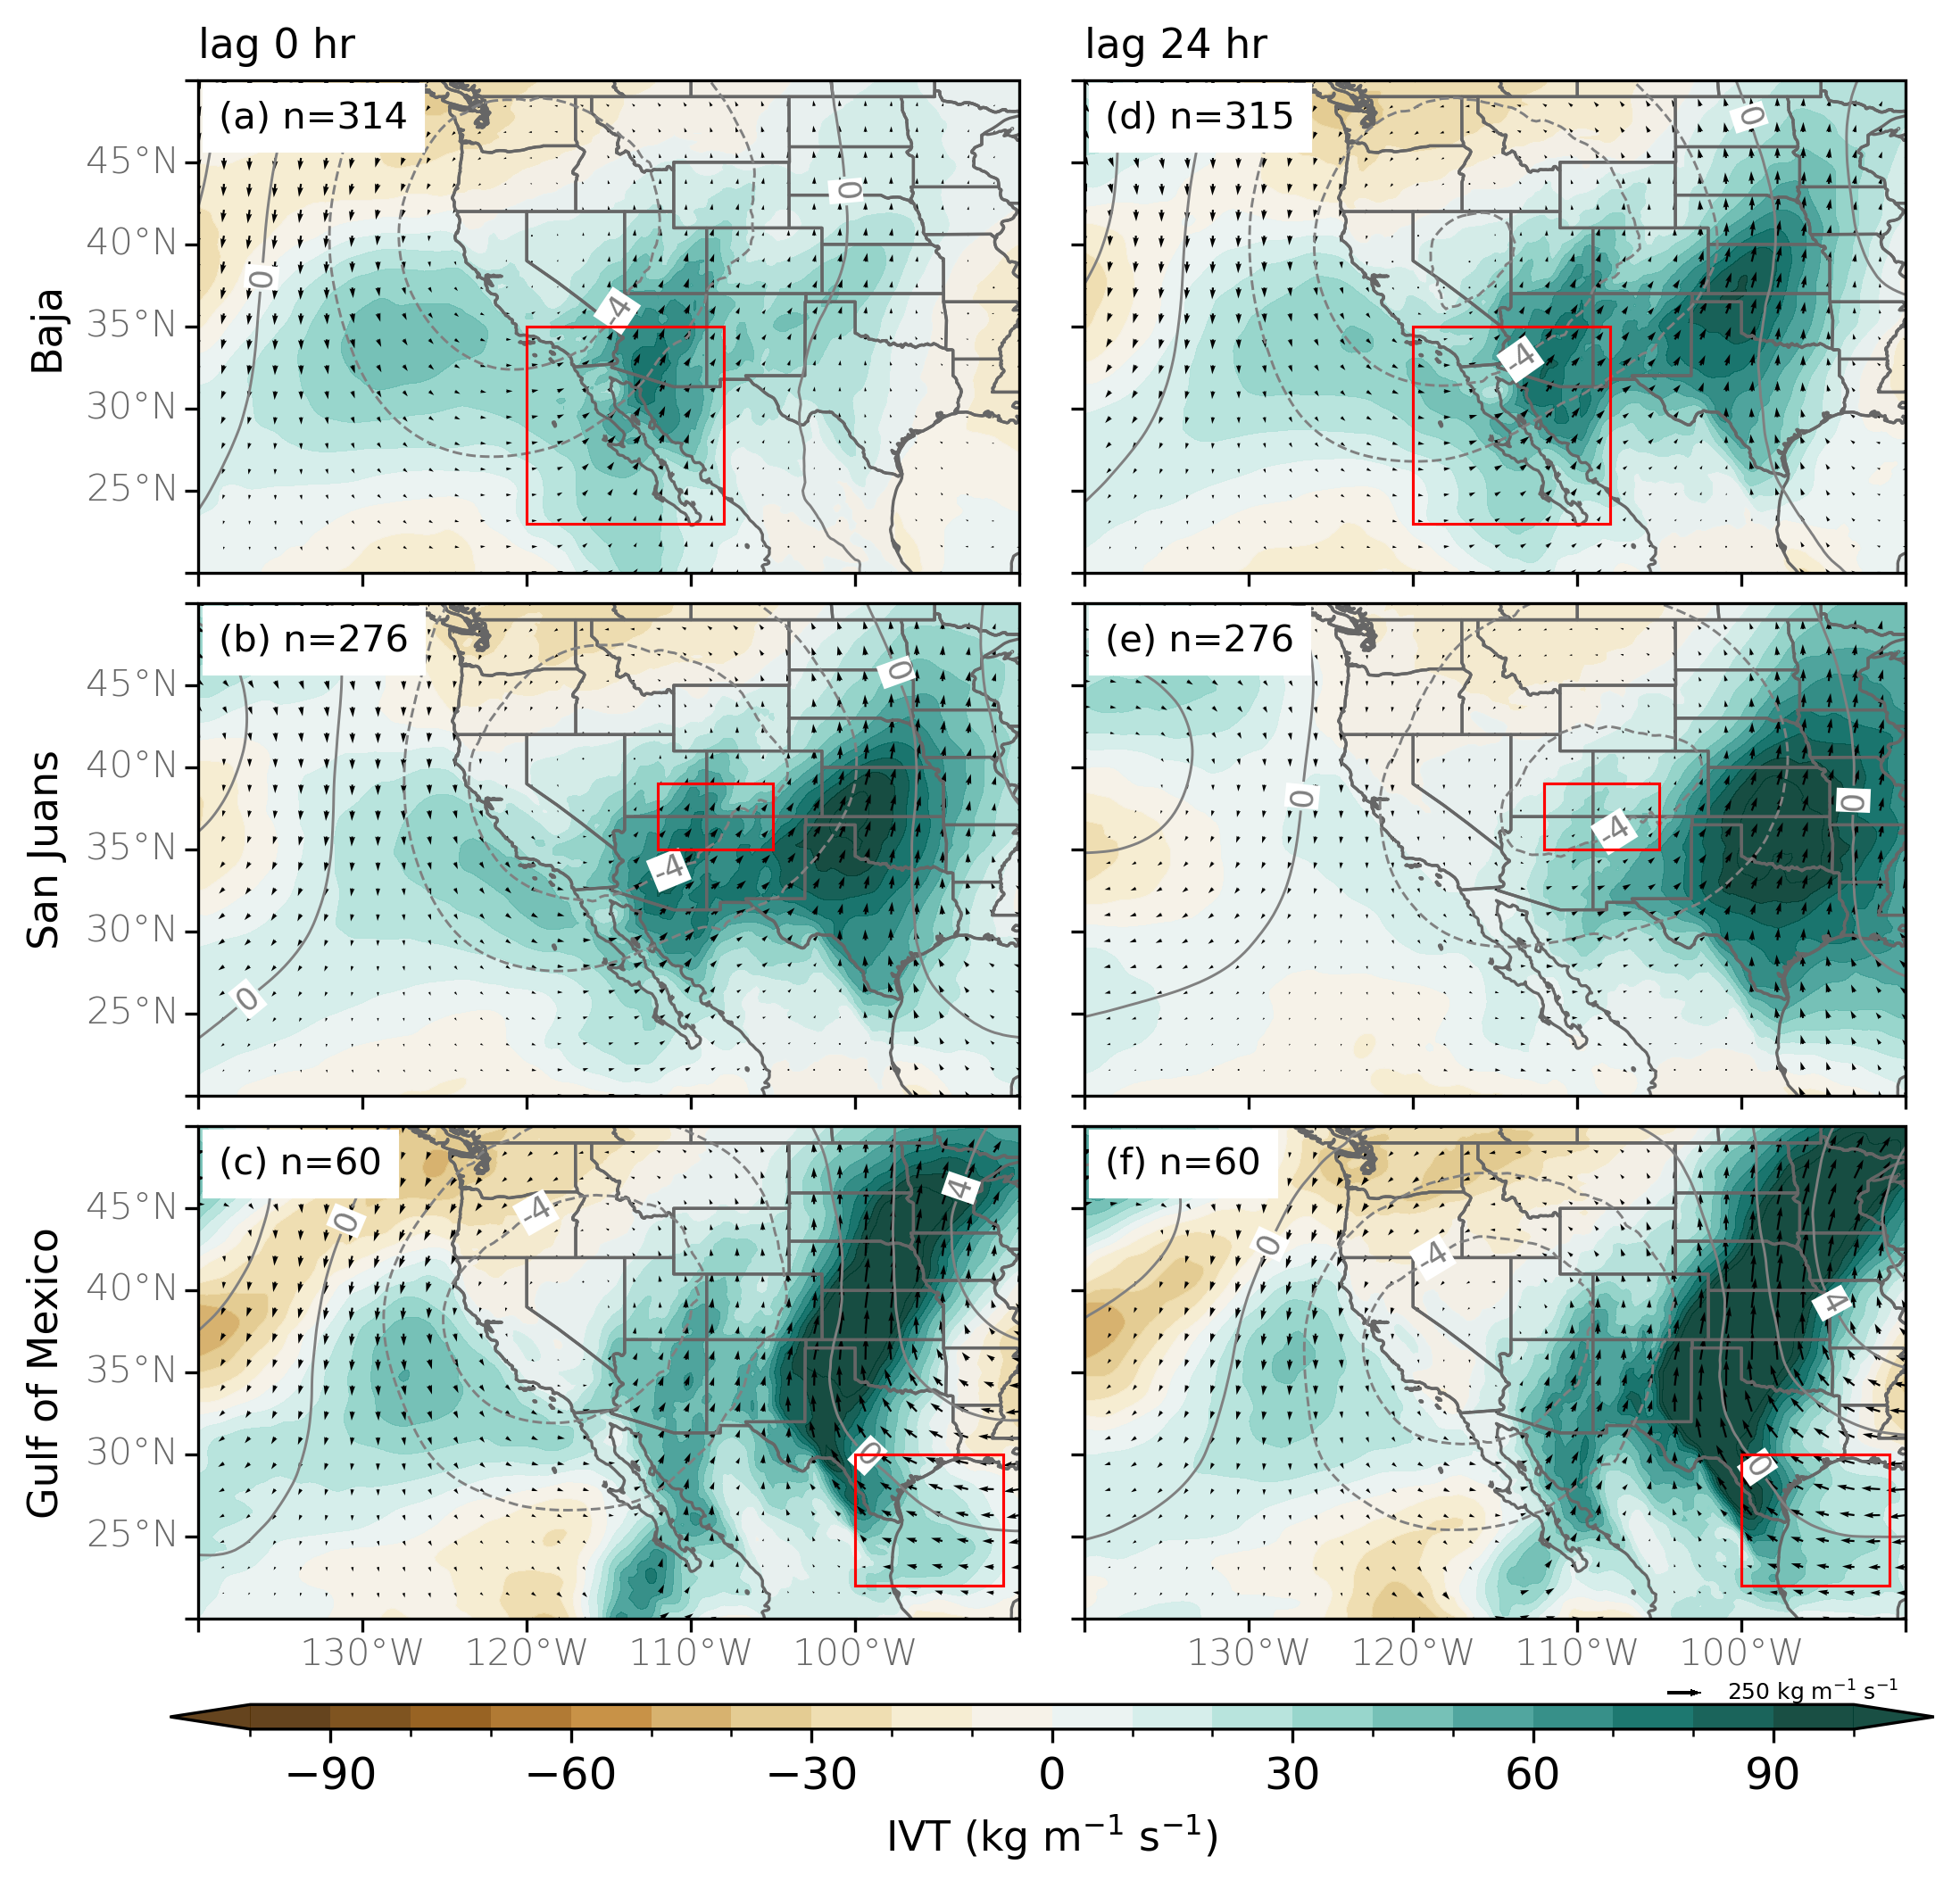

In [8]:
# Create figure
fig = plt.figure(figsize=(8.5, 8))
fig.dpi = 300
fname = path_to_figs + '{0}_IVT_700z_anom_composite'.format(ssn)
fmt = 'png'

# contour labels
kw_clabels = {'fontsize': 7, 'inline': True, 'inline_spacing': 7, 'fmt': '%i',
              'rightside_up': True, 'use_clabeltext': True}

nrows = 5
ncols = 2

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1, 1, 1, 0.05, 0.05], width_ratios = [1, 1], wspace=0.01, hspace=0.1)
## use gs[rows index, columns index] to access grids

#################
### COMPOSITE ###
#################

rowidx = [0, 1, 2]*2
colidx = [0]*3 + [1]*3
region_lst = ['baja', 'san_juan', 'gulf_of_mexico']*2
region_lbl = ['Baja', 'San Juans', 'Gulf of Mexico']*2
t_lbl = ['lag 0 hr']*3 + ['lag 24 hr']*3
lag_lst = [0]*3 + [1]*3
llats = [True]*3 + [False]*3
blons = [False, False, True]*2
for i, (region, lag) in enumerate(zip(region_lst, lag_lst)):
    ds = ds_hc.sel(region=region, lag=lag)
    tval = ds_tval.sel(region=region, lag=lag)
    ax = fig.add_subplot(gs[rowidx[i], colidx[i]], projection=mapcrs)
    ax = draw_basemap(ax, extent=ext, xticks=dx, yticks=dy, left_lats=llats[i], right_lats=False, bottom_lons=blons[i])
    ax.add_feature(cfeature.STATES, edgecolor='0.4', linewidth=0.8)
    
    # Contour Filled
    lats = ds.latitude.values
    lons = ds.longitude.values
    ivt = ds.ivt.values
    print(ivt.min(), ivt.max())
    cmap = cm.BrBG
    bnds = np.arange(-100., 110., 10)
    cbarticks = bnds[::2]
    norm = mcolors.BoundaryNorm(bnds, cmap.N)
    cf = ax.contourf(lons, lats, ivt, transform=datacrs,
                     levels=bnds, cmap=cmap, norm=norm, alpha=0.9, extend='both')

    # Wind barbs / vectors 
    uvec_mask = ds.ivtu.where((tval.ivtu == True) | (tval.ivtv == True)).values
    vvec_mask = ds.ivtv.where((tval.ivtu == True) | (tval.ivtv == True)).values

    Q = ax.quiver(lons, lats, uvec_mask, vvec_mask, transform=datacrs, 
              color='k', regrid_shape=20,
              angles='xy', scale_units='xy', scale=125, units='xy')

    # Contour Lines
    hgts = ds.z.values/9.80665 ## convert to geopotential height
    hgts = hgts/(10) # convert to meters # 750-hPa Heights
    print(hgts.min(), hgts.max())
    clevs = np.arange(-20, 22, 2)
    cs = ax.contour(lons, lats, hgts, transform=datacrs,
                    levels=clevs, colors='grey', linewidths=0.7)
    
    kw_clabels = {'fontsize': 8.5, 'inline': True, 'inline_spacing': 5, 'fmt': '%i', 'rightside_up': True, 'use_clabeltext': True}
    cl = ax.clabel(cs, clevs[::2], **kw_clabels)
    for txt in cl:
                txt.set_bbox(dict(facecolor='white', edgecolor='none', pad=0.5))



    ext3 = config[region]['ext']
    ax.add_patch(mpatches.Rectangle(xy=[ext3[0], ext3[2]], width=ext3[1]-ext3[0], height=ext3[3]-ext3[2],
                                        fill=False,
                                        edgecolor='r',
                                        linewidth=0.75,
                                        transform=datacrs,
                                        zorder=199))

    titlestring = '({0}) n={1}'.format(letter_lst[i], str(ds.ndays.values))
    ax.text(0.025, 0.96, titlestring, ha='left', va='top', transform=ax.transAxes, fontsize=10., backgroundcolor='white', zorder=101)

    if rowidx[i] == 0: # add column label to top row only
            ax.set_title(t_lbl[i], loc='left', fontsize=11)
        
    if colidx[i] == 0: # add row labels to the far left plot
        ax.text(-0.16, 0.5, region_lbl[i], va='bottom', ha='center',
            rotation='vertical', rotation_mode='anchor', fontsize=11,
            transform=ax.transAxes)


# quiver key
qk = ax.quiverkey(Q, 0.75, -.15, 250, '250 kg m$^{-1}$ s$^{-1}$', labelpos='E',
                  coordinates='axes', fontproperties={'size': 6.0})
# Colorbar (single)
cbax = plt.subplot(gs[-1,:]) # colorbar axis
cb = fig.colorbar(cf, cbax, orientation='horizontal', drawedges=False)
cb.set_label('IVT (kg m$^{-1}$ s$^{-1}$)', fontsize=11)
cb.ax.tick_params(labelsize=12)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)

# Show
plt.show()